# Demonstration of PINN method to solve Burger's linear second order equation
# ML Seminar, 2023-01-03
$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu u_{xx}$$
with initial condition 
$$u(0) = u_0(x)$$
- The solution is a function of points $(x_i, t_i)$.
- When feeding data to the neural network, we will feed $N$ points. 
- The first (batch) dimension is the point index, the second dimension is 2 ($x$ and $y$)

In [1]:
%load_ext autoreload
%autoreload 2 
# %matplotlib inline

In [2]:
import numpy as np
from torch import tensor as tt
import matplotlib.pyplot as plt
import pinn_burger_eq_functions as impl
from ipywidgets import interact
from DictX import DictX
import ipywidgets as widgets

# Main Code

## How does partial from functtools work?
* https://stackoverflow.com/questions/15299878/how-does-functools-partial-work
* https://www.geeksforgeeks.org/partial-functions-python/

## Information about Burger's equation
* https://en.wikipedia.org/wiki/Burgers%27_equation

## Physical Parameters

TOTAL_TIME = 6.0

dct = DictX()
dct.nu = 1.e-1  # viscosity
dct.x0 = tt(0.)  # left boundary
dct.xL = tt(2.)    # right boundary
# Might have to set this dynamically based on analytical solution at t=0
dct.u0 = tt(0.)     # IC on left boudnary 
dct.uL = tt(0.)     # IC on right boundary
dct.T0 = t0 = tt(0.)  # Initial time
dct.T1 = tt(TOTAL_TIME)    # Final simulation time during training
dct.N = 500  # number of points in the interior domain (Uniform distribution)
dct.N_IC = 30 # number of points on the line segment $x\in[x0, xL]$ at $t=0$ 
dct.N_BC = 30  # number of points on the segments x={x0,xL} and $t\in[T0, T1]$
dct.lr = 0.001  # Learning rate for Adam Optimizer

# Global dictionary to keep x and t so I can perform derivatives
# I can only take derivatives with respect to graph leaves
# A tensor slice is not a leaf. 

## Initial conditions, boundary conditions, interior points

In [3]:
# Dictionary, always accessible with the latest parameters
dct = impl.GlobDct()
print(list(dct.keys()))

[]


In [4]:
def exact_solution():
    dct = impl.GlobDict()
    x = dct.x
    t = dct.t
    nu = dct.nu
    return tt(np.exp(-nu * np.pi**2 * t) * np.sin(np.pi * x))   

In [29]:
def fill_dct():
    dct = impl.GlobDct()
    dct.x0 = tt(0.)
    dct.xL = tt(2.)
    dct.T0 = tt(0.)
    dct.T1 = tt(3.)
    dct.N = 1000
    dct.u0 = tt(0.)
    dct.uL = tt(0.)
    dct.N_IC = 300
    dct.N_BC = 80
    impl.interior(**dct)
    impl.BC(**dct)
    impl.IC(**dct)
    print("dct keys: ", list(dct.keys()))

fill_dct()

dct keys:  ['x_IC', 't_IC', 'pts_IC', 'u_IC', 'x0', 'xL', 'T0', 'T1', 'N', 'u0', 'uL', 'N_IC', 'N_BC', 'x', 't', 'pts', 't_left', 't_right', 'u_l', 'u_r', 'x_l', 'x_r', 'pts_left_BC', 'pts_right_BC']


In [25]:
@interact(N_IC=(50,300,50), rerun=True)
def plt_initial(N_IC, rerun):
    dct.N_IC = N_IC
    impl.IC(**dct)
    plt.scatter(impl.unwrap(dct.x_IC), unwrap(dct.u_IC), s = 5)
    plt.xlim(dct.x0-.05, dct.xL+.05)
    plt.ylim(dct.u_IC.min().item()-.05, dct.u_IC.max().item()+.05)
    plt.grid(True, alpha=.5)
    plt.title("Gordon", color="white")

interactive(children=(IntSlider(value=150, description='N_IC', max=300, min=50, step=50), Checkbox(value=True,…

In [8]:
dct.u_IC.max().item()

0.9999213218688965

## Physical Domain

In [9]:
dct = impl.GlobDct()
print(list(dct.keys()))

['x0', 'xL', 'T0', 'T1', 'N', 'u0', 'uL', 'N_IC', 'N_BC', 'x', 't', 'pts', 't_left', 't_right', 'u_l', 'u_r', 'x_l', 'x_r', 'pts_left_BC', 'pts_right_BC', 'x_IC', 't_IC', 'pts_IC', 'u_IC']


In [10]:
# The second argument allows the dictionary to be updated with geometric data
impl.IC(**dct)
impl.draw_initial_conditions()

interactive(children=(IntSlider(value=32, description='ms_', max=60, min=5), IntSlider(value=25, description='…

In [8]:
impl.draw_domain(**dct)

interactive(children=(IntSlider(value=32, description='ms_', max=60, min=5), IntSlider(value=25, description='…

* Every epoch, the points will change (set randomize checkbox to True)
* The randomization occurs in the interior and on the boundary points

In [9]:
def test_ic_bc():
    # Test the functions above
    # is requires_grad enabled
    # Do the functions return arrays of points (x,t)
    # All arrays have dimension (B,1) or (B,2). B is the batch size
    dct = impl.GlobDct()
    N = 12
    N_BC = 8
    N_IC = 8
    # pts = interior(N, dct.x0, dct.xL, dct.T0, dct.T1)
    pts = impl.interior(**dct)
    bc_l, bc_r, u_l, u_r = impl.BC(**dct)
    ic_x, u_init = impl.IC(**dct)

    print("bc_l: ", torch.min(bc_l), torch.max(bc_l))
    print("bc_r: ", torch.min(bc_r), torch.max(bc_r))
    print("pts: ", pts)
    print("ic_x: ", ic_x)
    print("ic_x: ", torch.min(ic_x), torch.max(ic_x))
    print("dct[x]: ", dct["x"])

#test_ic_bc()

## PINN model

## Derivatives

x = tt([1.,2.,3.], requires_grad=True).reshape(-1,1)
y = tt([4.,5.,6.], requires_grad=True).reshape(-1,1)
dct["xx"] = x
pts = torch.cat([x,y], dim=1)
loss = sum(pts**2).sum()
z = x.clone()[1:3]
pts, loss

dfdx(loss,dct["xx"])

## Loss

import torch.nn  as nn
NN = PINN(3, 10)
import torch.nn  as nn
print(NN)
# compute_loss(NN)

compute_loss(NN)

## Train Model

## Plot Solution

In [94]:
print(list(dct.keys()));

['nu', 'x0', 'xL', 'u0', 'uL', 'T0', 'T1', 'N', 'N_IC', 'N_BC', 'lr', 'x', 't', 'pts', 't_left', 't_right', 'u_l', 'u_r', 'x_l', 'x_r', 'pts_left_BC', 'pts_right_BC', 'x_IC', 't_IC', 'pts_IC', 'u_IC']


In [95]:
# how to create a button with @interact and ipywidgets?
# https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html


In [153]:
impl.plot_run()

interactive(children=(IntSlider(value=200, description='nb_epochs', max=2000, min=200, step=200), FloatSlider(…

In [81]:
# Create a python class that stores a dictionary as a variable in a singleton class

In [15]:
list(dct.keys())

['nu', 'x0', 'xL', 'u0', 'uL', 'T0', 'T1', 'N', 'N_IC', 'N_BC', 'lr']

In [26]:
dct.u_IC.Dshape

torch.Size([30, 1])

dct keys:  ['x_IC', 't_IC', 'pts_IC', 'u_IC', 'x0', 'xL', 'T0', 'T1', 'N', 'u0', 'uL', 'N_IC', 'N_BC', 'x', 't', 'pts', 't_left', 't_right', 'u_l', 'u_r', 'x_l', 'x_r', 'pts_left_BC', 'pts_right_BC']


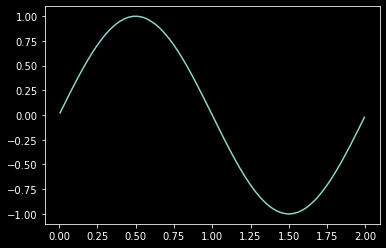

In [36]:
dct = impl.GlobDct()
fill_dct()
impl.IC(**dct)
list(dct.keys())
x = impl.unwrap(dct.x_IC)
u = impl.unwrap(dct.u_IC)
argx = np.argsort(x)
x = x[argx]
u = u[argx]
plt.plot(x,u)

# Create a collection of vertical sliders in a h or v-box

In [15]:
impl.plot_tab_structure()  # Equiv to display the return value

In [38]:
dir(type)

['__abstractmethods__',
 '__base__',
 '__bases__',
 '__basicsize__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dictoffset__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__flags__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__instancecheck__',
 '__itemsize__',
 '__le__',
 '__lt__',
 '__module__',
 '__mro__',
 '__name__',
 '__ne__',
 '__new__',
 '__prepare__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasscheck__',
 '__subclasses__',
 '__subclasshook__',
 '__text_signature__',
 '__weakrefoffset__',
 'mro']

In [39]:
dir(object)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']